# Analisis de la temperatura de Bogota  2007 - 2022

In [1]:
import pandas as pd
import warnings
import rpy2
warnings.filterwarnings('ignore')


In [2]:
%load_ext rpy2.ipython

In [3]:
import plotly.graph_objects as go

def plot_(title, *series):
    # Crear una figura
    fig = go.Figure()

    # Agregar cada serie de datos al gráfico
    for x_variable, y_variable, label in series:
        fig.add_trace(go.Scatter(
            x=x_variable,
            y=y_variable,
            mode='lines',
            name=label,
            line=dict(width=2)
        ))

    # Actualizar el tipo de eje x a 'date'
    fig.update_xaxes(type='date')

    # Ajustar el título para que esté centrado
    fig.update_layout(title_text=title, title_x=0.5)

    # Personalizar el selector de rango de fechas
    fig.update_layout(
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                         label="1d",
                         step="day",
                         stepmode="backward"),
                    dict(count=7,
                         label="1w",
                         step="day",
                         stepmode="backward"),
                    dict(count=1,
                         label="1m",
                         step="month",
                         stepmode="backward"),
                    dict(count=3,
                         label="3m",
                         step="month",
                         stepmode="backward"),
                    dict(count=6,
                         label="6m",
                         step="month",
                         stepmode="backward"),
                    dict(count=1,
                         label="1y",
                         step="year",
                         stepmode="backward"),
                    dict(count=2,
                         label="2y",
                         step="year",
                         stepmode="backward"),
                    dict(count=3,
                         label="3y",
                         step="year",
                         stepmode="backward"),
                    dict(count=5,
                         label="5y",
                         step="year",
                         stepmode="backward"),
                    dict(count=10,
                         label="10y",
                         step="year",
                         stepmode="backward"),
                    dict(count=20,
                         label="20y",
                         step="year",
                         stepmode="backward"),
                    dict(count=30,
                         label="30y",
                         step="year",
                         stepmode="backward"),
                    dict(count=50,
                         label="50y",
                         step="year",
                         stepmode="backward"),
                    dict(step="all")
                ])
            ),
            rangeslider=dict(
                visible=True
            ),
            type="date"
        ),
        yaxis=dict(
            autorange=True,
            type="linear"
        )
    )

    # Personalizar los títulos de los ejes
    fig.update_layout(
        xaxis_title="Tiempo",
        yaxis_title="Indice de producción"
    )

    # Personalizar la leyenda
    fig.update_layout(
        legend=dict(
            orientation="v",
            yanchor="top",
            y=1,
            xanchor="left",
            x=-.35
        )
    )

    # Mostrar el gráfico
    fig.show()


# 1 Importación de datos

In [4]:
data = pd.read_csv('../data/IPG2211A2N.csv')
df = pd.DataFrame(data)
df['DATE'] = pd.to_datetime(df['DATE'])

df.rename(columns={'IPG2211A2N': 'Index', 'DATE': 'Date'}, inplace=True)
df.head()

Date    Index
0 1962-01-01  24.3532
1 1962-02-01  23.7170
2 1962-03-01  23.5643
3 1962-04-01  22.6991
4 1962-05-01  22.5973

In [5]:
df.tail()

Date     Index
742 2023-11-01  100.1659
743 2023-12-01  109.7093
744 2024-01-01  125.9050
745 2024-02-01  106.5653
746 2024-03-01  100.4793

In [6]:
%R -i df

Además: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


In [7]:
plot_("Producción Industrial: Electricidad y Gas, USA", (df["Date"], df["Index"], ""))


In [8]:
%%R
head(df)

        Date   Index
0 1962-01-01 24.3532
1 1962-02-01 23.7170
2 1962-03-01 23.5643
3 1962-04-01 22.6991
4 1962-05-01 22.5973
5 1962-06-01 23.3607


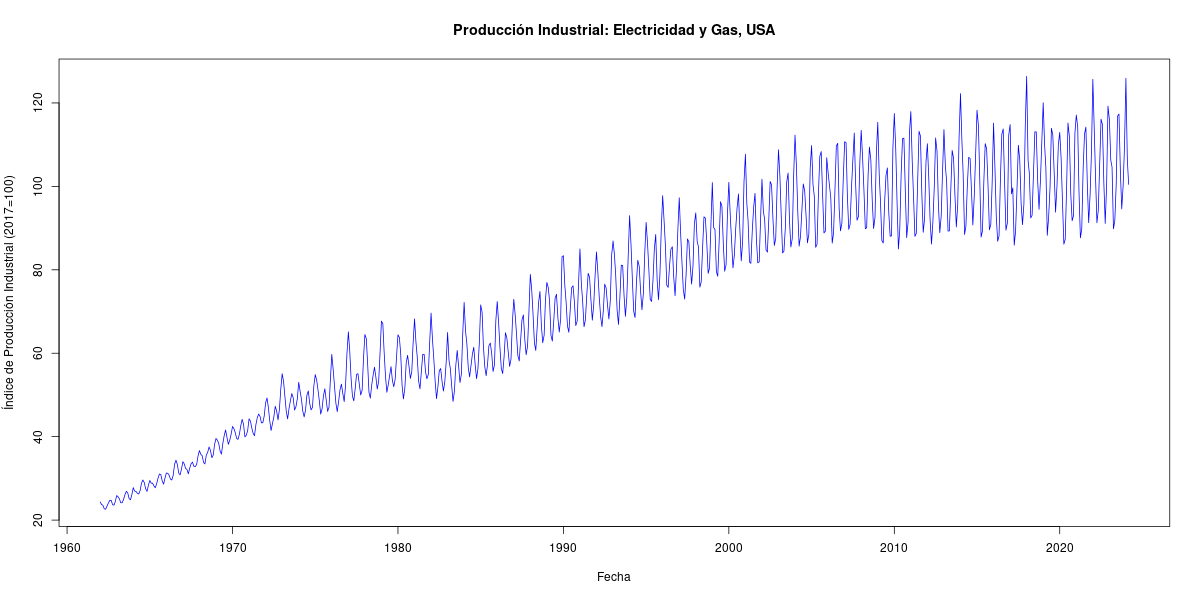

In [9]:
%%R -w 1200 -h 600
    plot(df$Date, df$Index, type='l', col='blue', 
         xlab='Fecha', ylab='Índice de Producción Industrial (2017=100)', 
         main='Producción Industrial: Electricidad y Gas, USA')

## 1.1 Funcion de autocorrelación

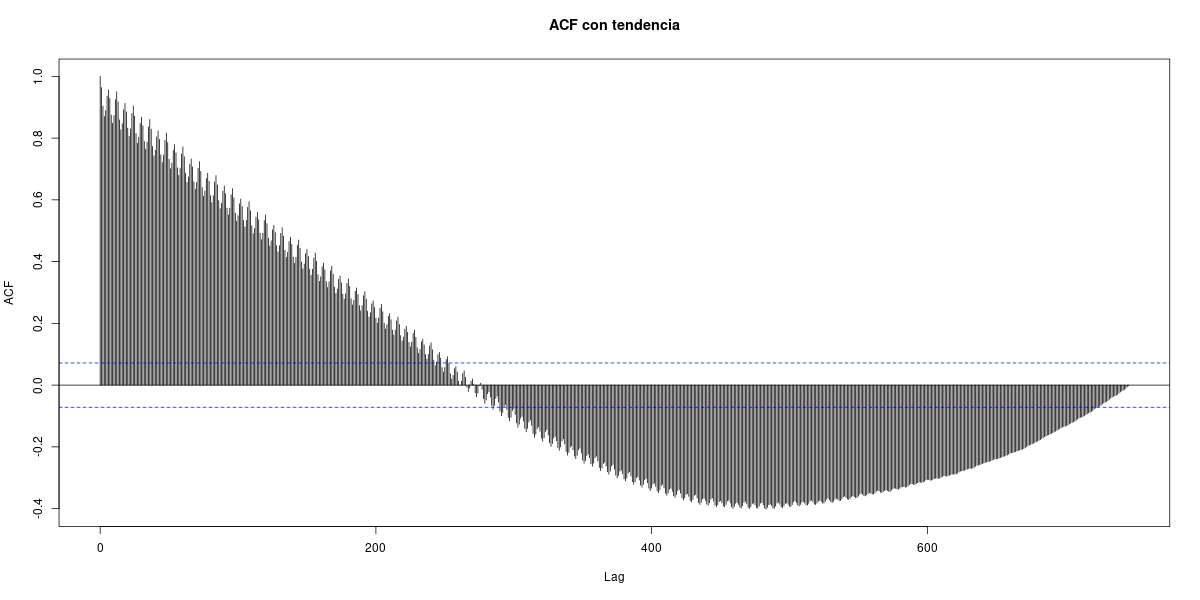

In [10]:
%%R  -w 1200 -h 600
acf(df$Index, lag.max = 1000, main = "ACF con tendencia")

# 2 Estabilización de la Varianza

## 2.1. Estimación de $\lambda$

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


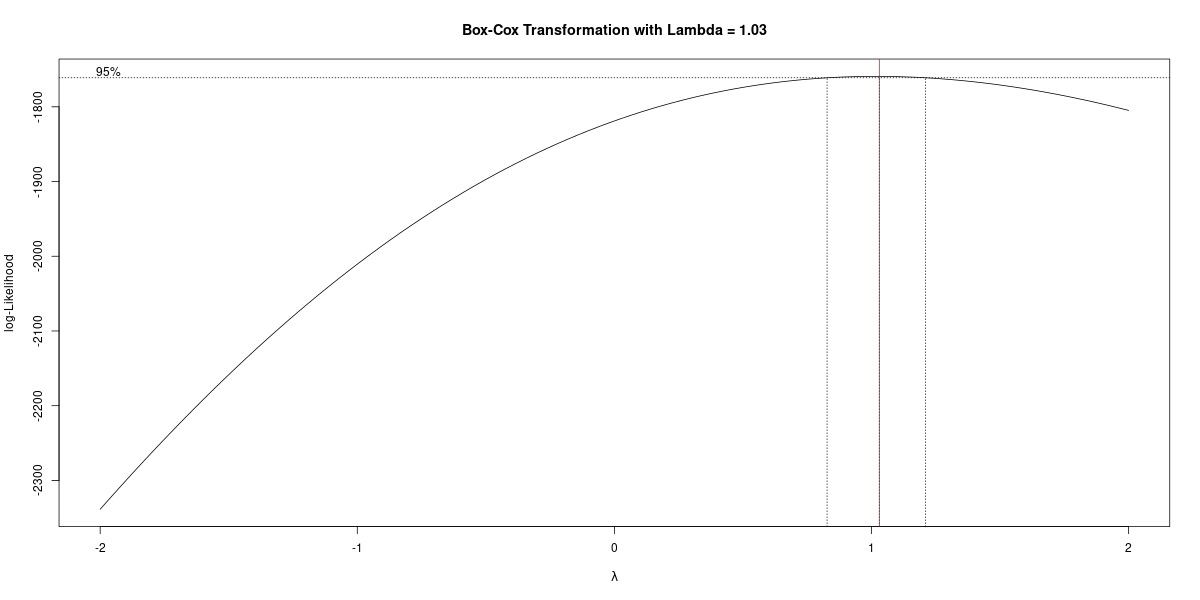

In [11]:
%%R -w 1200 -h 600

library(forecast)
library(MASS)

df$Date <- as.Date(df$Date)
df$Index <- ts(df$Index, frequency=12, start=c(1985,1))
df <- na.omit(df)

b <- boxcox(df$Index ~ 1)
lambda <- b$x[which.max(b$y)]

title(main = paste("Box-Cox Transformation with Lambda =", round(lambda, 3) ))
abline(v = lambda, col = "red")


## 2.2 Grafica de Box-cox

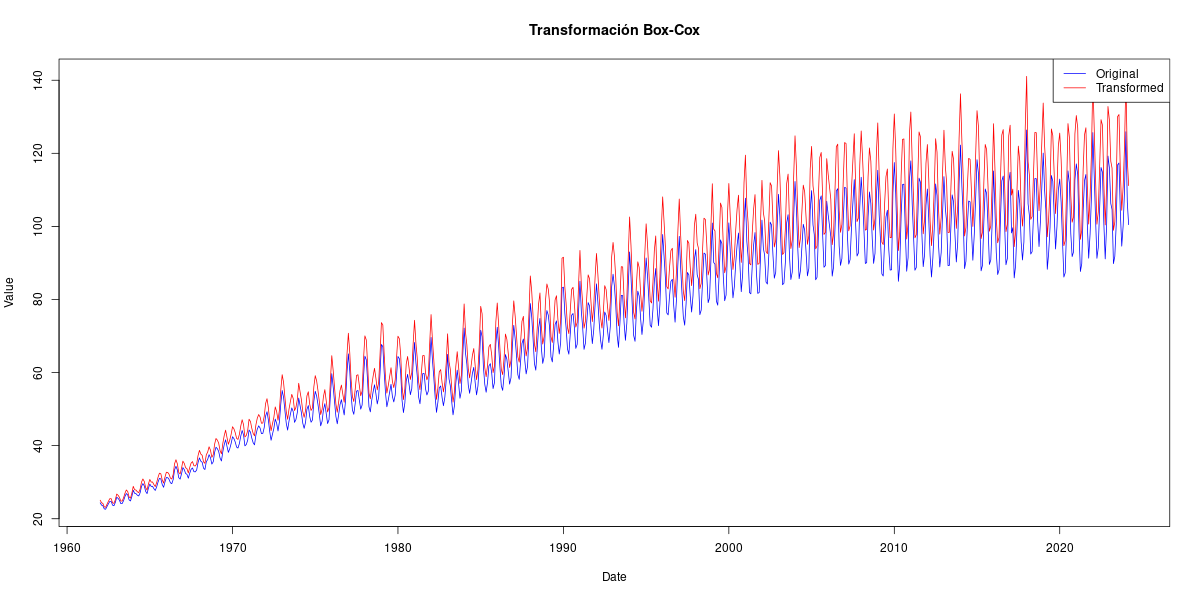

In [12]:
%%R -w 1200 -h 600

# Plot Box cox
transformed_data <- forecast::BoxCox(df$Index, lambda = lambda)
plot(df$Date, df$Index, type = "l", col = "blue", ylim = range(c(df$Index, transformed_data)), 
     xlab = "Date", ylab = "Value", main = paste("Transformación Box-Cox"))
lines(df$Date, transformed_data, col = "red")
legend("topright", legend = c("Original", "Transformed"), col = c("blue", "red"), lty = 1)


In [13]:
%%R
head(transformed_data)

[1] 25.06743 24.36688 24.19882 23.24722 23.13533 23.97479


In [14]:
%R -o  transformed_data

In [15]:

plot_('Transformación Box-Cox', (df["Date"], df["Index"], "Datos originales"), (df["Date"], transformed_data, "Box-cox"))

# 3 Estimación de la tendencia

## 3.1. Loess

In [16]:
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt


lowess = sm.nonparametric.lowess(transformed_data, np.arange(len(transformed_data)))

# Extraer los valores de la tendencia
trend_lowess = lowess[:, 1]

In [17]:
plot_('Tendencia por Lowess', (df["Date"], trend_lowess, "Tendencia"), (df["Date"], transformed_data, "Box-cox"))

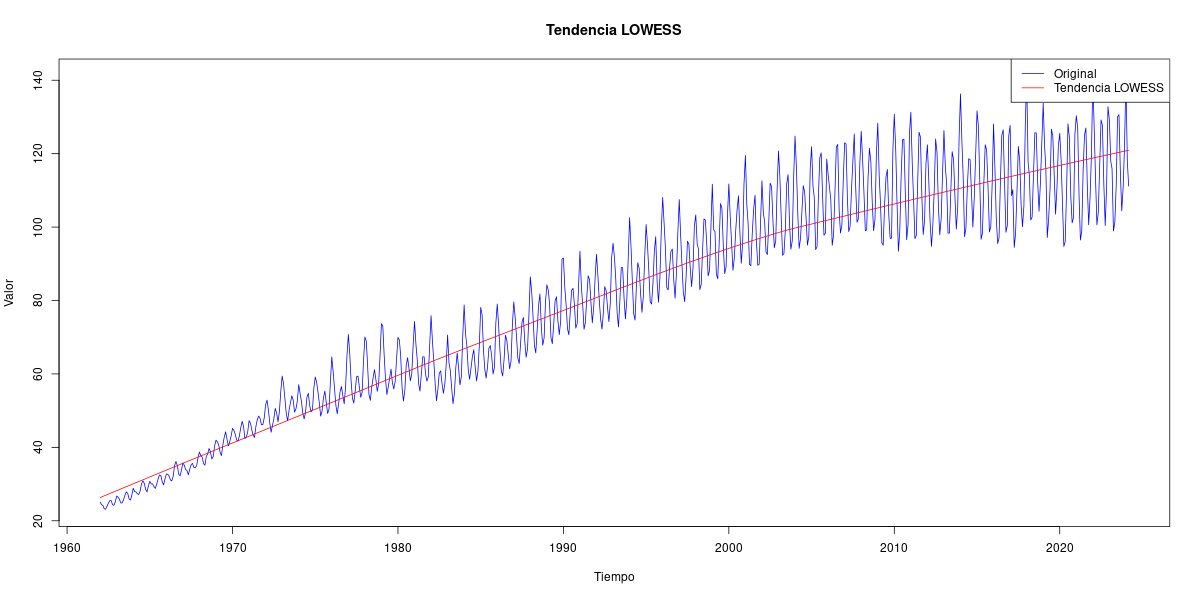

In [18]:
%%R -w 1200 -h 600

# Supongamos que tienes un dataframe df con una columna llamada 'Index'

# Calcular LOWESS
trend_lowess_R <- lowess(transformed_data)

# Crear un gráfico de la serie original y la tendencia LOWESS
plot(df$Date,transformed_data, type='l', col='blue', xlab='Tiempo', ylab='Valor', main='Tendencia LOWESS')
lines(df$Date, trend_lowess_R$y, col='red')
legend("topright", legend=c("Original", "Tendencia LOWESS"), col=c("blue", "red"), lty=1)


In [19]:
%%R 

trend_lowess_R_y <- trend_lowess_R[['y']]

In [20]:
%R -o trend_lowess_R_y

In [21]:
plot_('Tendencia Lowess', (df["Date"], trend_lowess_R_y, "Tendencia en R"), 
      (df["Date"], transformed_data, "Box-cox"), 
      (df["Date"], trend_lowess, "Tendencia en python"))

## 3.2. Datos sin tendencia

In [22]:
detrend = transformed_data - trend_lowess_R_y

In [23]:
plot_('Sin tendencia',
      (df["Date"], transformed_data, "Box-cox"), 
      (df["Date"], detrend, "Sin tendencia"))

## 3.3 Auto funcion de correlación

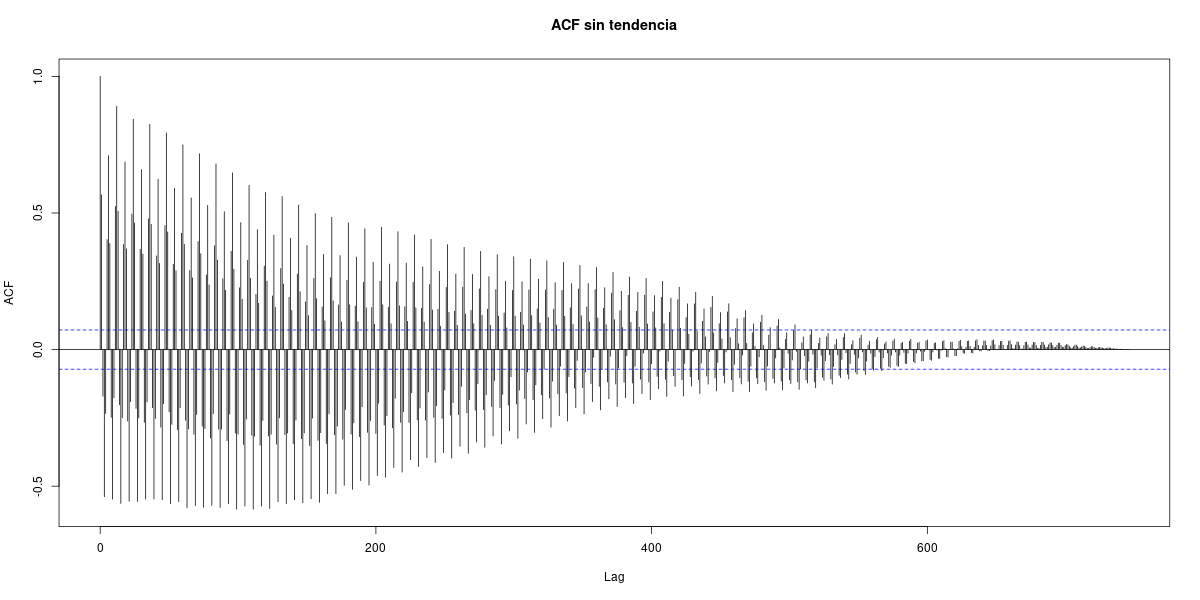

In [24]:
%%R -w 1200 -h 600
detrend = transformed_data - trend_lowess_R_y
acf(detrend, lag.max = 1000, main = "ACF sin tendencia")


Attaching package: ‘astsa’

The following object is masked from ‘package:forecast’:

    gas



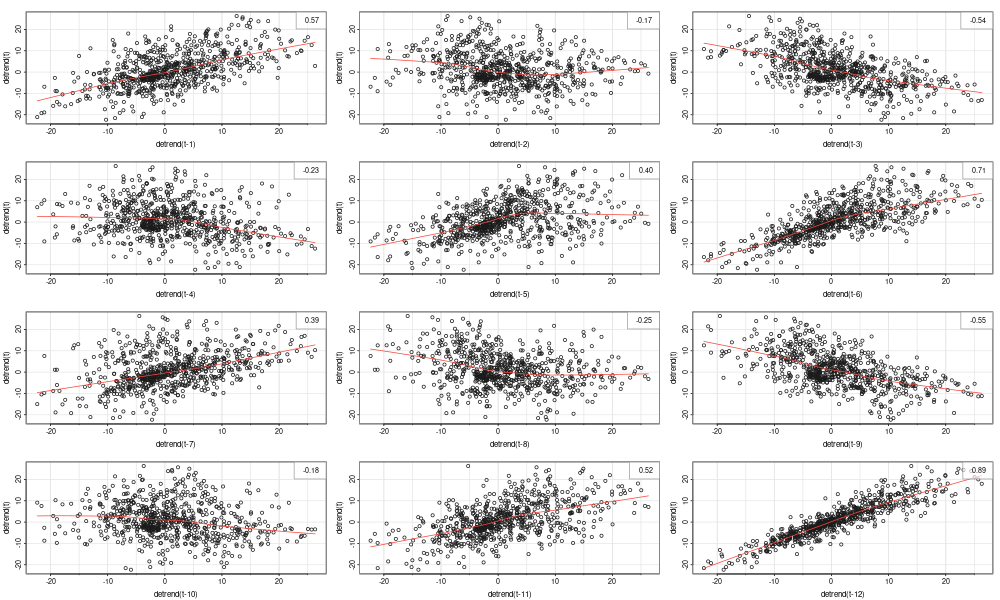

In [25]:
%%R -w 1000 -h 600
options(repr.plot.width=20, repr.plot.height=6)
library(astsa)
astsa::lag1.plot(detrend, 12)

$time.lag
 [1]  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24

$mutual.information
 [1] 1.83325232 0.24536156 0.09849479 0.21426769 0.08804175 0.18947809
 [7] 0.40509605 0.17106210 0.08585288 0.22343832 0.07383292 0.18693408
[13] 0.74908271 0.17456288 0.07277845 0.22028691 0.07537247 0.17596684
[19] 0.37733060 0.13653508 0.07190166 0.22538737 0.07303011 0.15288148
[25] 0.65714719

$units
[1] "Nats"

$n.partitions
[1] 9

attr(,"class")
[1] "mutualInf"


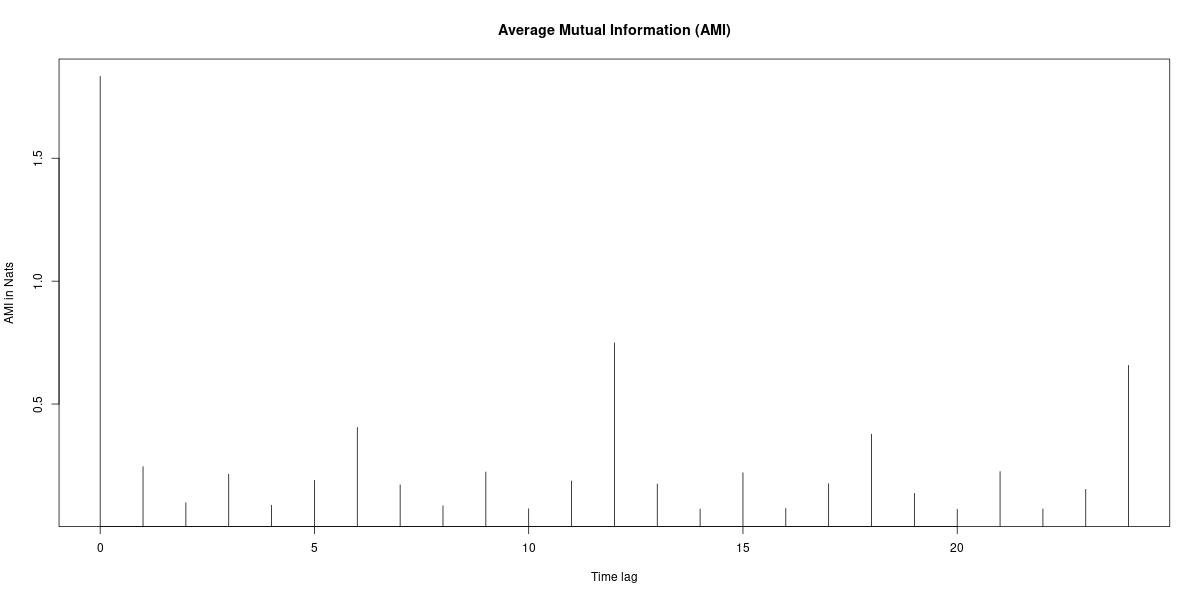

In [26]:
%%R -w 1200 -h 600
nonlinearTseries::mutualInformation(detrend,lag.max = 24, main="Información mutua")

# 4. Estacionalidad

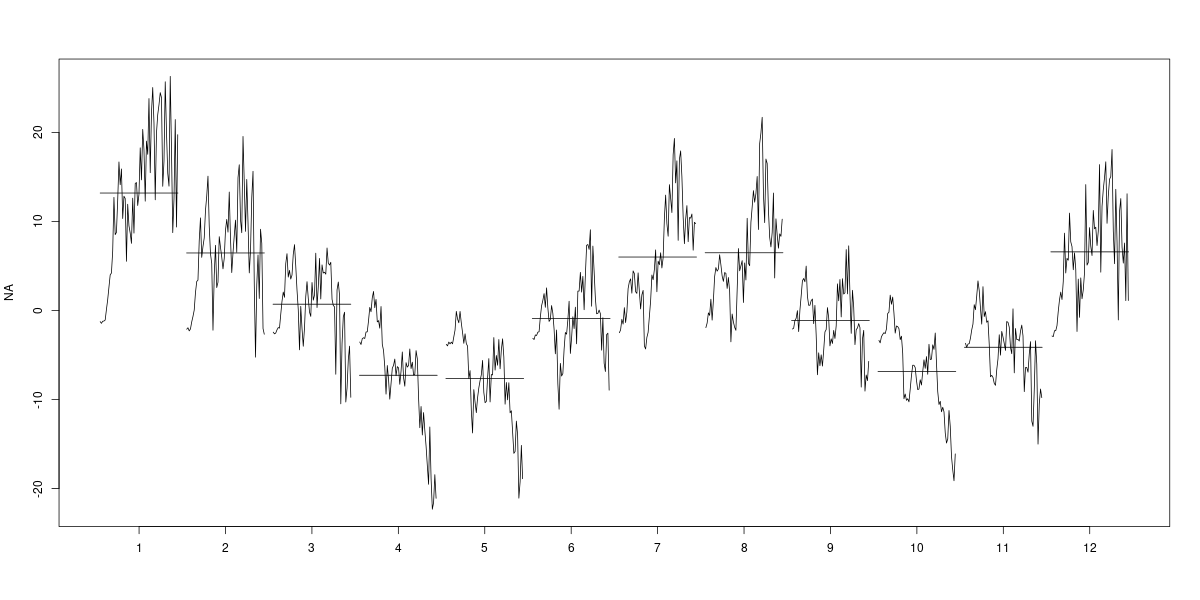

In [27]:
%%R -w 1200 -h 600

monthplot(detrend)

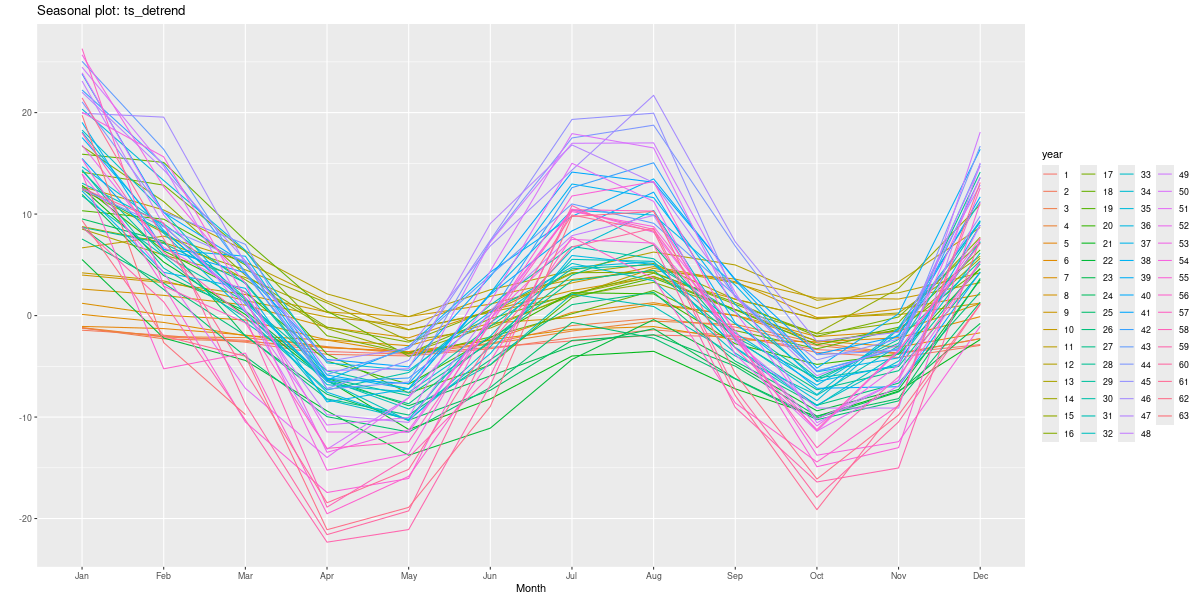

In [28]:
%%R -w 1200 -h 600

library(forecast)
ts_detrend <- ts(detrend, frequency = 12)
ggseasonplot(ts_detrend)

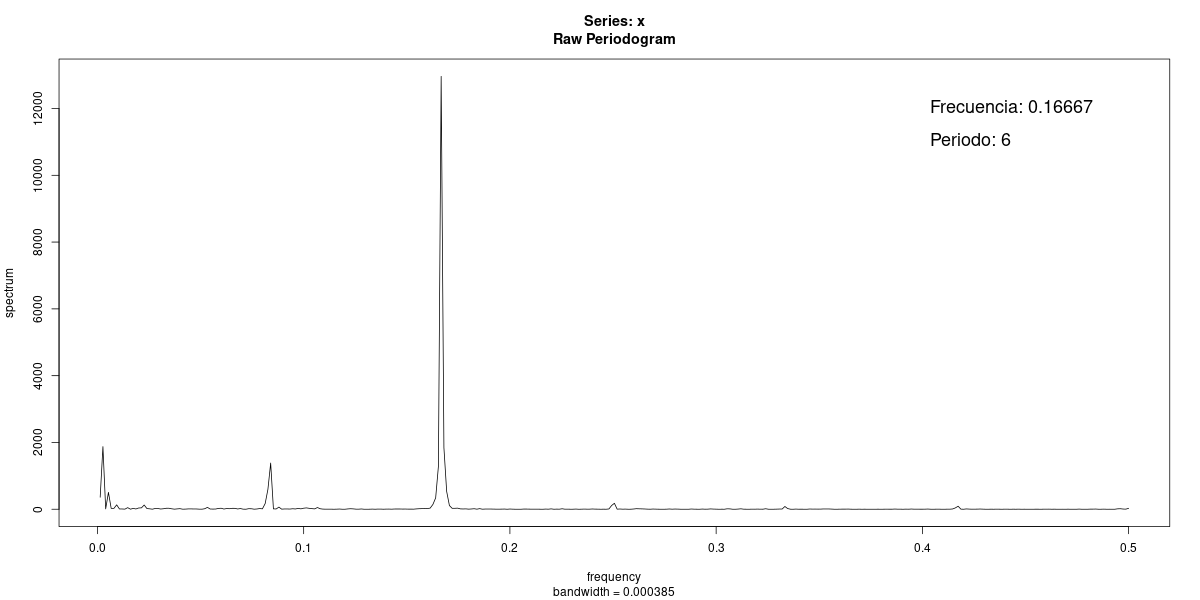

In [29]:
%%R -w 1200 -h 600

# Calculate the periodogram for data2
Periogram <- spectrum(as.numeric(detrend), log = 'no')

# Get the index where the periodogram maximizes
ubicacion <- which.max(Periogram$spec)

# Get the frequency value at the index where the periodogram maximizes
max_freq <- Periogram$freq[ubicacion]

# Calculate the corresponding period
max_period <- 1 / max_freq

# Plot the periodogram for data2

# Add text annotation for frequency and period
text(.4, 12000, sprintf("Frecuencia: %s", round(max_freq, 5)), pos = 4, cex = 1.5)
text(.4, 11000, sprintf("Periodo: %s", round(max_period, 2)), pos = 4, cex = 1.5)


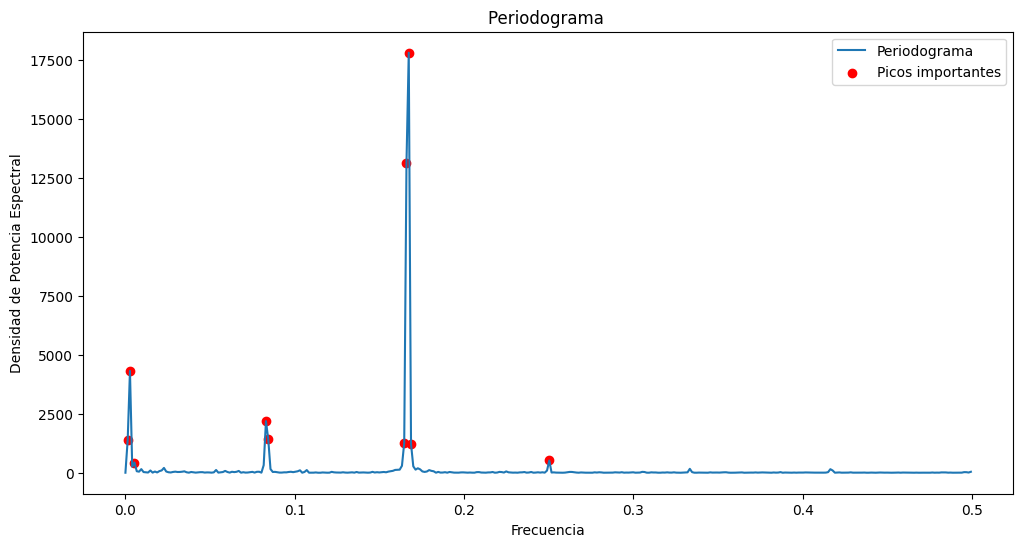

Los 10 Picos mas grandes para el periodograma son:


0         1           2          3          4           5  \
Frecuencia  0.167336  0.165997    0.002677   0.082999   0.084337    0.001339   
Periodo     5.976000  6.024194  373.500000  12.048387  11.857143  747.000000   

                   6         7         8           9  
Frecuencia  0.164659  0.168675  0.250335    0.005355  
Periodo     6.073171  5.928571  3.994652  186.750000

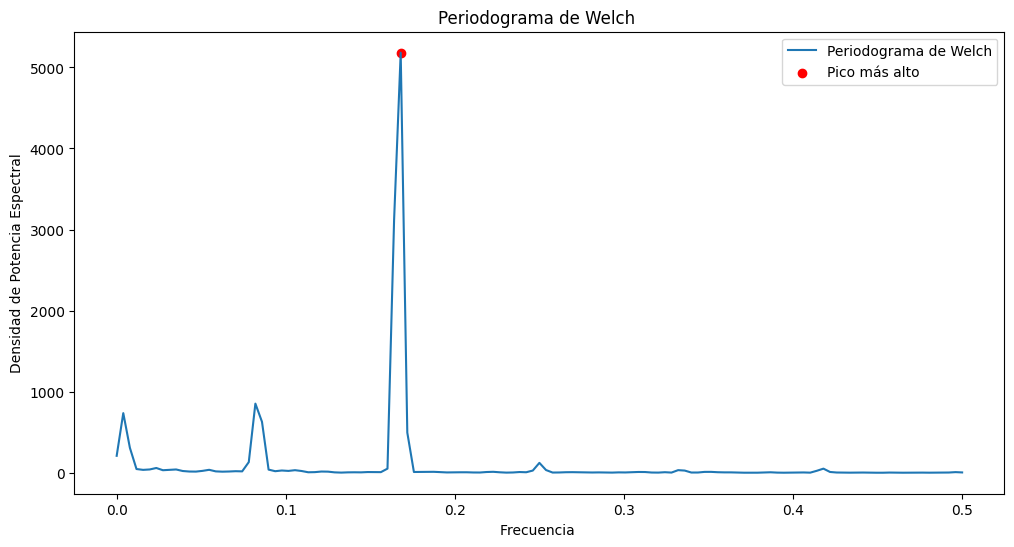

El pico más notorio se da: 
 - Frecuencia: 0.16796875  
 - Periodo: 5.953488372093023 


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import heapq


# Calcular el periodograma
f, Pxx_den = sp.signal.periodogram(detrend)

# Encontrar los picos más importantes
peaks_indices = heapq.nlargest(10, range(len(Pxx_den)), key=Pxx_den.__getitem__)
f_freq = f[peaks_indices]
f_period = 1 / f[peaks_indices]

# Calcular el periodograma de Welch
f_welch, Pxx_den_welch = sp.signal.welch(detrend)

# Encontrar el pico más alto del periodograma de Welch
max_index_value_welch = np.argmax(Pxx_den_welch)
frecuencia_max_welch = f_welch[max_index_value_welch]
frecuencia_pico_welch = 1 / frecuencia_max_welch




# Graficar el periodograma
plt.figure(figsize=(12, 6))
plt.plot(f, Pxx_den, label='Periodograma')
plt.scatter(f[peaks_indices], Pxx_den[peaks_indices], color='red', label='Picos importantes')

plt.xlabel('Frecuencia')
plt.ylabel('Densidad de Potencia Espectral')
plt.title('Periodograma ')
plt.legend()
plt.show()

print('Los 10 Picos mas grandes para el periodograma son:')

# Crear DataFrame con las frecuencias y los periodos
data = {'Frecuencia': f_freq, 'Periodo': f_period}
df_frecuencias_periodos = pd.DataFrame(data)

# Mostrar el DataFrame
display(df_frecuencias_periodos.T)

# Graficar el periodograma de Welch
plt.figure(figsize=(12, 6))
plt.plot(f_welch, Pxx_den_welch, label='Periodograma de Welch')
plt.scatter(frecuencia_max_welch, Pxx_den_welch[max_index_value_welch], color='red', label='Pico más alto')

plt.xlabel('Frecuencia ')
plt.ylabel('Densidad de Potencia Espectral')
plt.title('Periodograma de Welch ')
plt.legend()
plt.show()

print(f'El pico más notorio se da: \n - Frecuencia: {frecuencia_max_welch}  \n - Periodo: {frecuencia_pico_welch} ')






# 5. Modelado 

In [31]:
%%R

library(forecast)
library(ggplot2)


df <- ts(df$Index, start = c(1962, 1), frequency = 12)
n = round(length(df)*0.8)
print(n)
print(time(df)[n])

train <- window(df, start = c(1962, 1), end = c(2011, 9))
test <- window(df, start = c(2011, 10), end = c(2024, 3))

[1] 598
[1] 2011.75


## 5.1. Holt-Winters

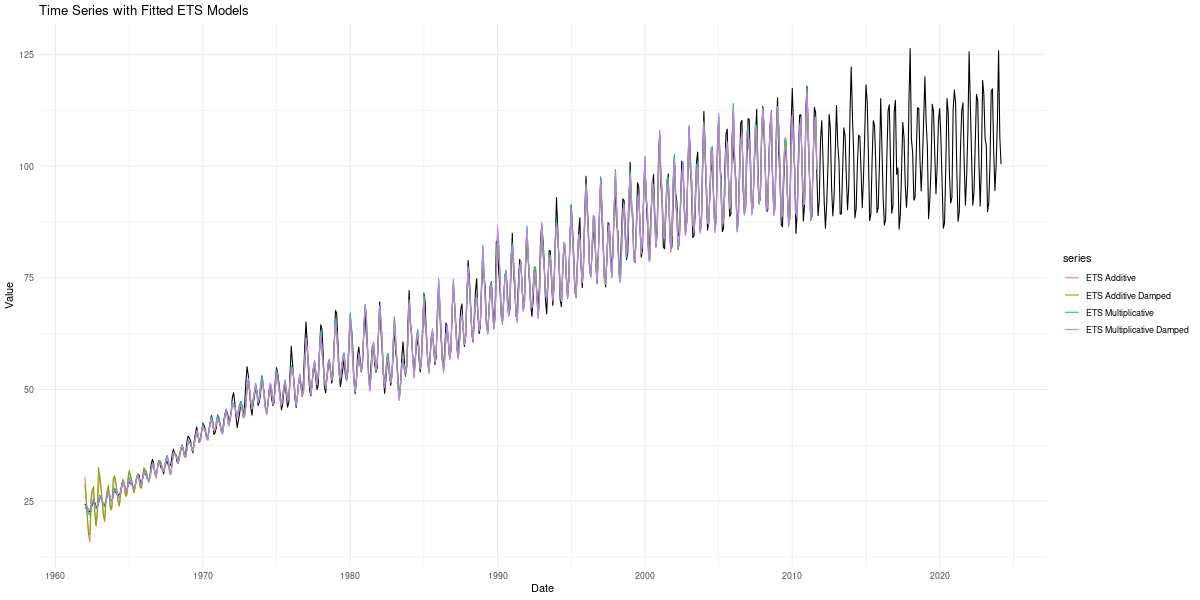

In [32]:
%%R -w 1200 -h 600
# Load required packages
library(forecast)
library(ggplot2)

# Fit an ETS model to the time series
# Fit ETS additive model
model_ets_additive <- ets(train, model = "AAA")
model_ets_additive_D <- ets(train, model = "AAA", damped = TRUE)

# Fit ETS multiplicative model
model_ets_multiplicative <- ets(train, model = "MAM")
model_ets_multiplicative_d <- ets(train, model = "MAM", damped = TRUE)


#fitted
fitted_AAA <- fitted(model_ets_additive)
fitted_AAdA <- fitted(model_ets_additive_D)
fitted_MAM <- fitted(model_ets_multiplicative)
fitted_MAdM <- fitted(model_ets_multiplicative_d)

# Plot the time series
autoplot(df) +
  autolayer(fitted(model_ets_additive), series = "ETS Additive") +
  autolayer(fitted(model_ets_multiplicative), series = "ETS Multiplicative") +
  autolayer(fitted(model_ets_additive_D), series = "ETS Additive Damped") +
  autolayer(fitted(model_ets_multiplicative_d), series = "ETS Multiplicative Damped") +
  xlab("Date") +
  ylab("Value") +
  ggtitle("Time Series with Fitted ETS Models") +
  theme_minimal()


In [33]:
%R -o fitted_AAA -o fitted_AAdA -o fitted_MAM -o fitted_MAdM

In [34]:
plot_('Metodos ETS', (df["Date"], df["Index"], "Original"), 
      (df["Date"], fitted_AAA, "ETS Aditivo"), (df["Date"], fitted_MAM, "ETS Multiplicativo"),
      (df["Date"], fitted_AAdA, "ETS Aditivo Amortiguado"), (df["Date"], fitted_MAdM, "ETS Multiplicativo Amortiguado"))

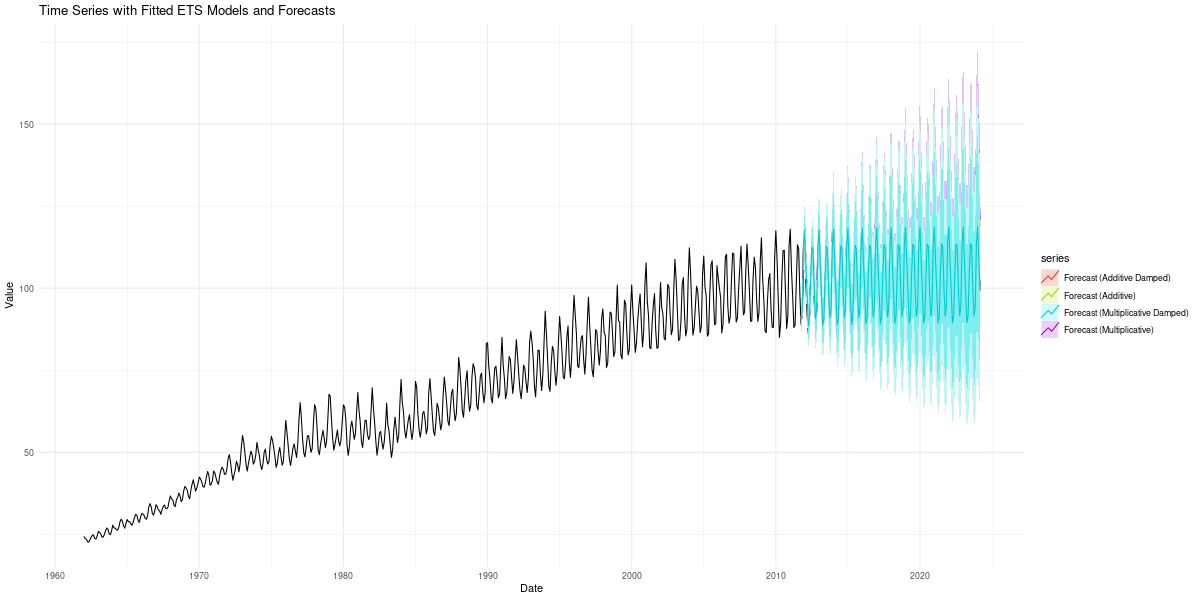

In [35]:
%%R -w 1200 -h 600

library(forecast)

forecast_additive <- forecast(model_ets_additive, h = 150)
forecast_additive_D <- forecast(model_ets_additive_D, h = 150)
forecast_multiplicative <- forecast(model_ets_multiplicative, h = 150)
forecast_multiplicative_d <- forecast(model_ets_multiplicative_d, h = 150)

# Plot the time series with forecasts
autoplot(df) +
  autolayer(forecast_additive, series = "Forecast (Additive)") +
  autolayer(forecast_additive_D, series = "Forecast (Additive Damped)") +
  autolayer(forecast_multiplicative, series = "Forecast (Multiplicative)") +
  autolayer(forecast_multiplicative_d, series = "Forecast (Multiplicative Damped)") +
  labs(x = "Date", y = "Value") +
  ggtitle("Time Series with Fitted ETS Models and Forecasts") +
  theme_minimal()

In [36]:
%%R

library(knitr)

# Calculate error metrics
accuracy_additive <- accuracy(forecast_additive, test)
accuracy_additive_D <- accuracy(forecast_additive_D, test)
accuracy_multiplicative <- accuracy(forecast_multiplicative, test)
accuracy_multiplicative_d <- accuracy(forecast_multiplicative_d, test)

# Store error metrics in a data frame
error_metrics_ETS <- data.frame(
  Model = c("Additive", "Additive Damped", "Multiplicative", "Multiplicative Damped"),
  RMSE = c(accuracy_additive[2, "RMSE"], accuracy_additive_D[2, "RMSE"], accuracy_multiplicative[2, "RMSE"], accuracy_multiplicative_d[2, "RMSE"]),
  MAE = c(accuracy_additive[2, "MAE"], accuracy_additive_D[2, "MAE"], accuracy_multiplicative[2, "MAE"], accuracy_multiplicative_d[2, "MAE"]),
  MAPE = c(accuracy_additive[2, "MAPE"], accuracy_additive_D[2, "MAPE"], accuracy_multiplicative[2, "MAPE"], accuracy_multiplicative_d[2, "MAPE"]),
  MASE = c(accuracy_additive[2, "MASE"], accuracy_additive_D[2, "MASE"], accuracy_multiplicative[2, "MASE"], accuracy_multiplicative_d[2, "MASE"])
)



In [37]:
%R -o error_metrics_ETS
error_metrics_ETS

Model       RMSE        MAE       MAPE      MASE
1               Additive  11.209675   9.958719   9.807272  4.026745
2        Additive Damped   3.653966   2.899310   2.801727  1.172318
3         Multiplicative  13.002036  11.452741  11.157767  4.630844
4  Multiplicative Damped   3.644674   2.903812   2.811191  1.174138

El modelo **Additive Damped** es el que presenta mejor resultados en los errores de la predición siendo el modelo escogido de los **ETS**

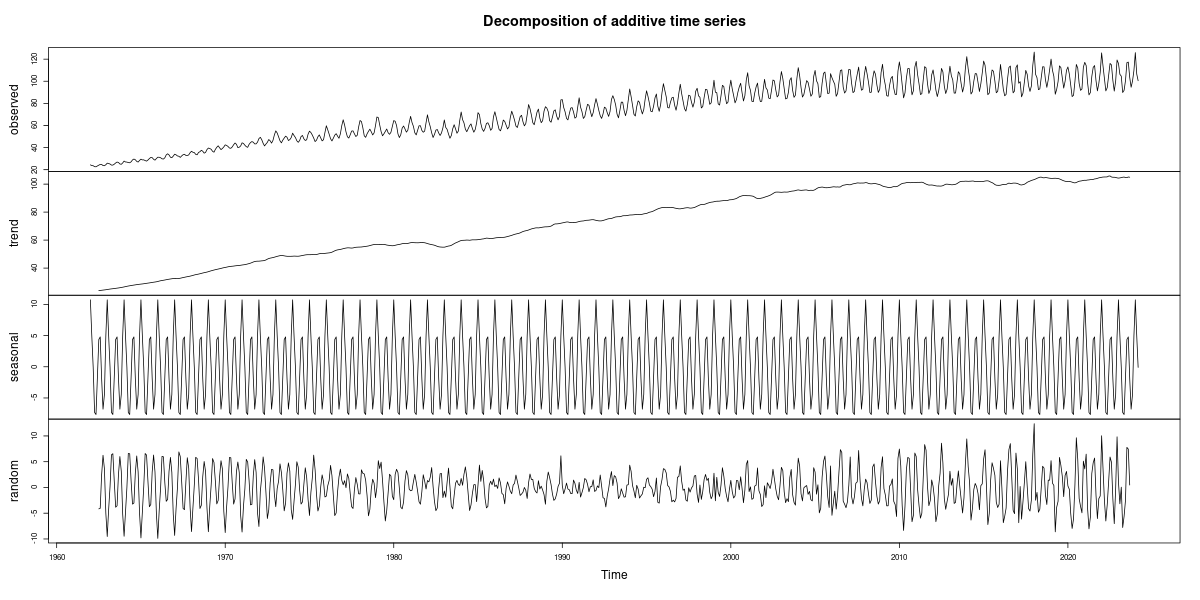

In [38]:
%%R -w 1200 -h 600
decomposed <- decompose(df, type='additive')

# Graficar las componentes de la descomposición
plot(decomposed)

## 5.2 SARIMA

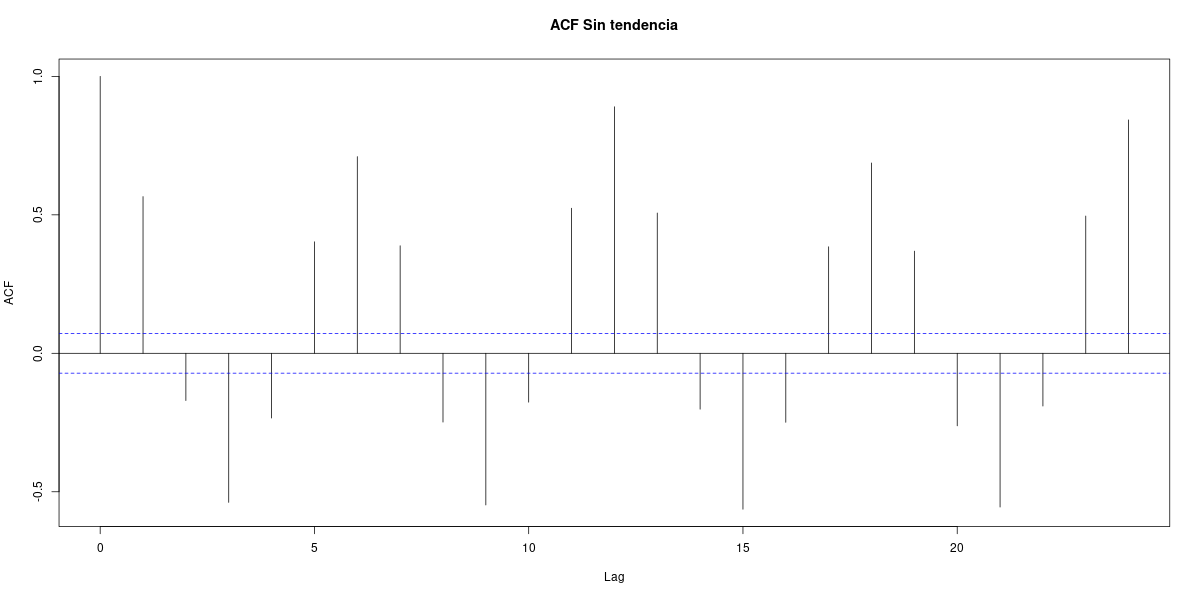

In [39]:
%%R -w 1200 -h 600
acf(detrend, lag.max = 24, main = "ACF Sin tendencia")

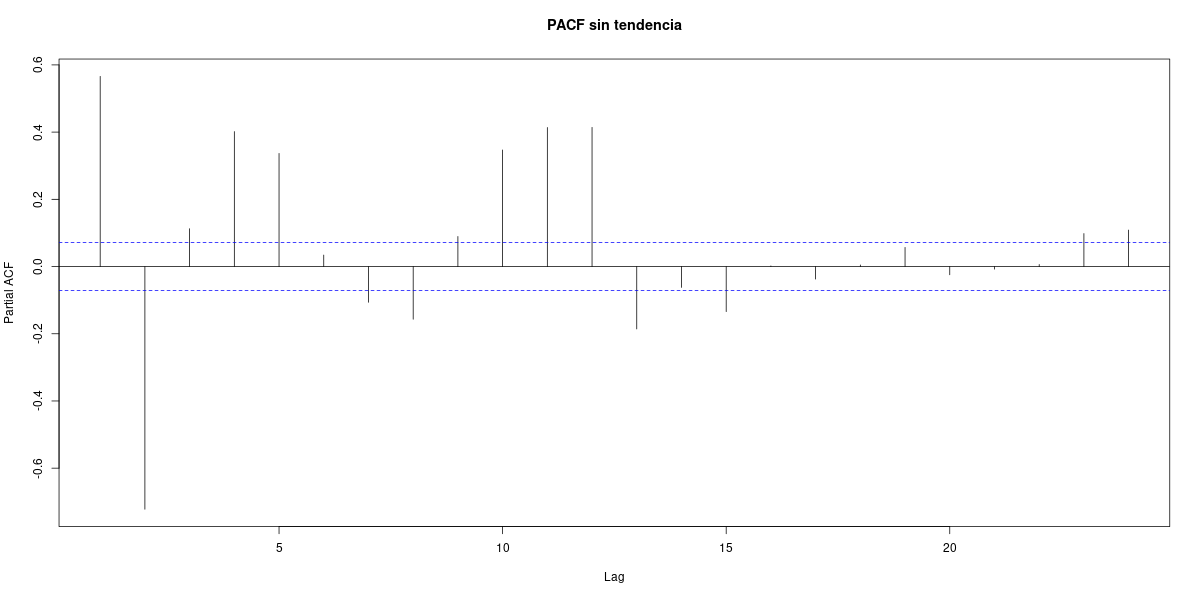

In [40]:
%%R -w 1200 -h 600
pacf(detrend, lag.max = 24, main = "PACF sin tendencia")

In [41]:
%%R

ARIMA1 = auto.arima(train)
ARIMA1

Series: train 
ARIMA(2,0,2)(0,1,1)[12] with drift 

Coefficients:
         ar1      ar2      ma1      ma2     sma1   drift
      1.2263  -0.2501  -0.5346  -0.2812  -0.6547  0.1324
s.e.  0.1329   0.1201   0.1311   0.0728   0.0313  0.0163

sigma^2 = 3.201:  log likelihood = -1170.72
AIC=2355.44   AICc=2355.64   BIC=2386.04


In [42]:
%%R
#ETS(A,Ad,A) <-->	ARIMA(1,0,m+1)(0,1,0)[m]

ARIMA2 <- Arima(train, order=c(1,0,13), seasonal=list(order=c(0,1,0), period=12))
ARIMA2

Series: train 
ARIMA(1,0,13)(0,1,0)[12] 

Coefficients:
          ar1     ma1     ma2     ma3     ma4     ma5     ma6     ma7     ma8
      -0.3801  1.1588  0.7729  0.5490  0.4682  0.4649  0.5267  0.5274  0.4980
s.e.   0.1238  0.1196  0.1157  0.1021  0.0862  0.0909  0.0903  0.0898  0.0892
         ma9    ma10    ma11     ma12     ma13
      0.4203  0.4038  0.5524  -0.1788  -0.3088
s.e.  0.0869  0.0815  0.0890   0.1015   0.0426

sigma^2 = 3.122:  log likelihood = -1166.52
AIC=2363.04   AICc=2363.89   BIC=2428.62


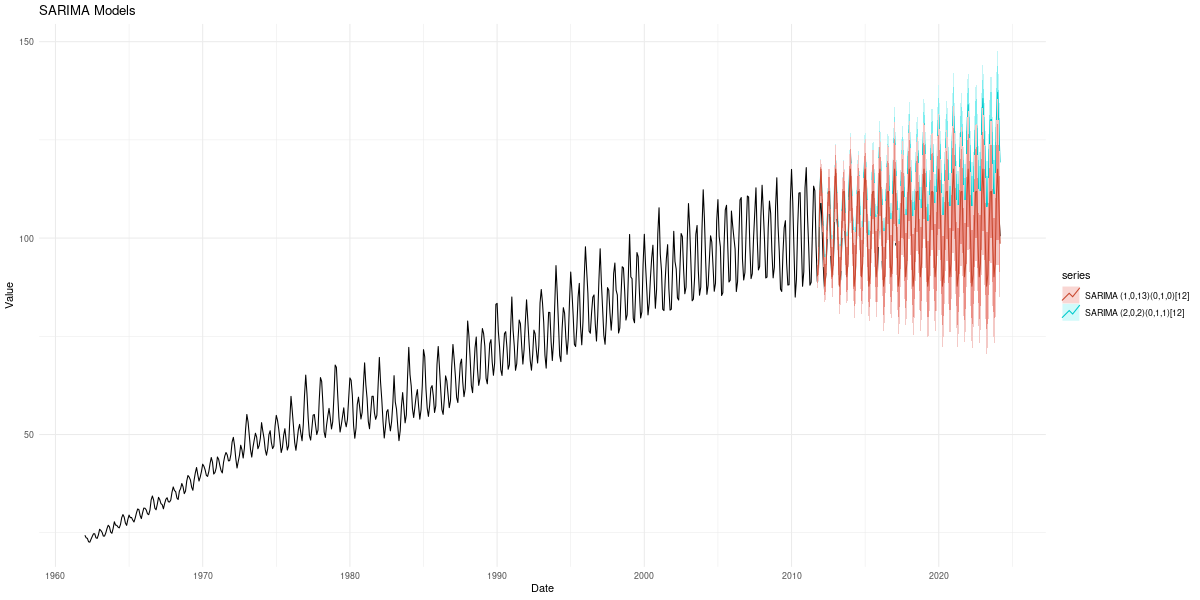

In [43]:
%%R -w 1200 -h 600
# Realizar pronósticos con el modelo ajustado
sarima_forecast1 <- forecast(ARIMA1, h = length(test))
sarima_forecast2 <- forecast(ARIMA2, h = length(test))

# Mostrar un gráfico de la serie temporal y los pronósticos
autoplot(df)+
  autolayer(sarima_forecast1, series = "SARIMA (2,0,2)(0,1,1)[12]") +
  autolayer(sarima_forecast2, series = "SARIMA (1,0,13)(0,1,0)[12]") +
  xlab("Date") +
  ylab("Value") +
  ggtitle("SARIMA Models ") +
  theme_minimal()

In [44]:
%%R
acc1 <- accuracy(sarima_forecast1, test)
acc2 <- accuracy(sarima_forecast2, test)

# Almacenar métricas de error en un marco de datos
error_metrics_sarima <- data.frame(
  Model = c("SARIMA (2,0,2)(0,1,1)[12]", "SARIMA (1,0,13)(0,1,0)[12]"),
  RMSE = c(acc1[2, "RMSE"], acc2[2, "RMSE"]),
  MAE = c(acc1[2, "MAE"], acc2[2, "MAE"]),
  MAPE = c(acc1[2, "MAPE"], acc2[2, "MAPE"]),
  MASE = c(acc1[2, "MASE"], acc2[2, "MASE"])
)


In [45]:
%R -o error_metrics_sarima
error_metrics_sarima

Model       RMSE       MAE      MAPE      MASE
1   SARIMA (2,0,2)(0,1,1)[12]  11.016951  9.760369  9.630362  3.946544
2  SARIMA (1,0,13)(0,1,0)[12]   3.681239  2.924519  2.819925  1.182511

**PREGUNTAR** ACI vs RMSE, MAE, MAPE

## 5.3 RED NEURONAL

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tensorflow as tf
from datetime import timedelta

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, TimeSeriesSplit, GridSearchCV

import tensorflow.keras as keras

In [47]:
train_weight = 0.8
split = int(len(df) * train_weight)

df.index = pd.to_datetime(df['Date'])
df.drop(columns=['Date'], inplace=True)
df_train = df['Index'].iloc[:split]
df_test = df['Index'].iloc[split:]
df

Index
Date                
1962-01-01   24.3532
1962-02-01   23.7170
1962-03-01   23.5643
1962-04-01   22.6991
1962-05-01   22.5973
...              ...
2023-11-01  100.1659
2023-12-01  109.7093
2024-01-01  125.9050
2024-02-01  106.5653
2024-03-01  100.4793

[747 rows x 1 columns]

In [48]:
# Scaling

mu = float(df_train.mean())
sigma = float(df_train.std())

stdize_input = lambda x: (x - mu) / sigma

df_train = df_train.apply(stdize_input)
df_test = df_test.apply(stdize_input)
len(df_train)

597

In [49]:
import pandas as pd
import numpy as np

def get_lagged_features(df, n_steps, n_steps_ahead):
    """
    df: pandas DataFrame of time series to be lagged
    n_steps: number of lags, i.e., sequence length
    n_steps_ahead: forecasting horizon
    """
    lag_list = []
    
    # Generate lagged features
    for lag in range(n_steps + n_steps_ahead - 1, n_steps_ahead - 1, -1):
        lag_list.append(df.shift(lag))
    
    # Stack lagged features along the third dimension
    lag_array = np.stack([i.values for i in lag_list], axis=-1)
    
    # Drop NaN values resulting from shifting
    lag_array = lag_array[n_steps + n_steps_ahead - 1:]
    
    # Reshape lag_array to add the last dimension
    lag_array = np.expand_dims(lag_array, axis=-1)
    
    return lag_array


In [50]:
n_steps = 12
n_steps_ahead = 1

x_train = get_lagged_features(df_train, n_steps, n_steps_ahead)
y_train =  df_train.values[n_steps + n_steps_ahead - 1:]
y_train_timestamps = df_train.index[n_steps + n_steps_ahead - 1:]

x_test = get_lagged_features(df_test, n_steps, n_steps_ahead)
y_test =  df_test.values[n_steps + n_steps_ahead - 1:]
y_test_timestamps = df_test.index[n_steps + n_steps_ahead - 1:]


print([tensor.shape for tensor in (x_train, y_train, x_test, y_test)])

[(585, 12, 1), (585,), (138, 12, 1), (138,)]


In [51]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# Define the function to create the Keras models
def create_model_1(optimizer='adam', kernel_regularizer=None):
    model = Sequential()
    model.add(Dense(64, input_dim=x_train.shape[1], activation='relu', kernel_regularizer=kernel_regularizer))
    model.add(Dense(32, activation='relu', kernel_regularizer=kernel_regularizer))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

def create_model_2(optimizer='adam', kernel_regularizer=None):
    model = Sequential()
    model.add(Dense(128, input_dim=x_train.shape[1], activation='relu', kernel_regularizer=kernel_regularizer))
    model.add(Dense(64, activation='relu', kernel_regularizer=kernel_regularizer))
    model.add(Dense(32, activation='relu', kernel_regularizer=kernel_regularizer))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

def create_model_3(optimizer='adam', kernel_regularizer=None):
    model = Sequential()
    model.add(Dense(32, input_dim=x_train.shape[1], activation='relu', kernel_regularizer=kernel_regularizer))
    model.add(Dense(16, activation='relu', kernel_regularizer=kernel_regularizer))
    model.add(Dense(8, activation='relu', kernel_regularizer=kernel_regularizer))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

# Define custom scorer for GridSearchCV
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Define parameter grid for GridSearchCV
param_grid = {
    'batch_size': [16, 32],
    'epochs': [20, 30],
    'optimizer': ['adam', 'rmsprop'],
    'kernel_regularizer': [None, 'l1', 'l2']
}

# Create KerasRegressor for each model
model_1 = KerasRegressor(build_fn=create_model_1, verbose=0)
model_2 = KerasRegressor(build_fn=create_model_2, verbose=0)
model_3 = KerasRegressor(build_fn=create_model_3, verbose=0)

# Define time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Create GridSearchCV for each model
grid_1 = GridSearchCV(estimator=model_1, param_grid=param_grid, cv=tscv, scoring=mse_scorer, verbose=2)
grid_2 = GridSearchCV(estimator=model_2, param_grid=param_grid, cv=tscv, scoring=mse_scorer, verbose=2)
grid_3 = GridSearchCV(estimator=model_3, param_grid=param_grid, cv=tscv, scoring=mse_scorer, verbose=2)

# Fit GridSearchCV for each model
grid_result_1 = grid_1.fit(x_train, y_train)
grid_result_2 = grid_2.fit(x_train, y_train)
grid_result_3 = grid_3.fit(x_train, y_train)

# Summarize results for each model
print("Model 1 - Best: %f using %s" % (grid_result_1.best_score_, grid_result_1.best_params_))
print("Model 2 - Best: %f using %s" % (grid_result_2.best_score_, grid_result_2.best_params_))
print("Model 3 - Best: %f using %s" % (grid_result_3.best_score_, grid_result_3.best_params_))


Fitting 5 folds for each of 24 candidates, totalling 120 fits


2024-05-08 15:32:16.650456: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-05-08 15:32:16.650542: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (plealm): /proc/driver/nvidia/version does not exist
2024-05-08 15:32:16.652358: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV] END batch_size=16, epochs=20, kernel_regularizer=None, optimizer=adam; total time=   1.4s
[CV] END batch_size=16, epochs=20, kernel_regularizer=None, optimizer=adam; total time=   1.3s
[CV] END batch_size=16, epochs=20, kernel_regularizer=None, optimizer=adam; total time=   1.5s
[CV] END batch_size=16, epochs=20, kernel_regularizer=None, optimizer=adam; total time=   1.7s
[CV] END batch_size=16, epochs=20, kernel_regularizer=None, optimizer=adam; total time=   1.9s
[CV] END batch_size=16, epochs=20, kernel_regularizer=None, optimizer=rmsprop; total time=   1.3s
[CV] END batch_size=16, epochs=20, kernel_regularizer=None, optimizer=rmsprop; total time=   1.8s
[CV] END batch_size=16, epochs=20, kernel_regularizer=None, optimizer=rmsprop; total time=   1.8s
[CV] END batch_size=16, epochs=20, kernel_regularizer=None, optimizer=rmsprop; total time=   1.8s
[CV] END batch_size=16, epochs=20, kernel_regularizer=None, optimizer=rmsprop; total time=   2.0s
[CV] END batch_size=16, epochs=20, 

In [52]:

# Guardar los mejores modelos
best_model_1 = grid_result_1.best_estimator_.model
best_model_1.save('best_model_1.h5')

best_model_2 = grid_result_2.best_estimator_.model
best_model_2.save('best_model_2.h5')

best_model_3 = grid_result_3.best_estimator_.model
best_model_3.save('best_model_3.h5')


In [53]:
# Predicciones sobre datos de entrenamiento y prueba
y_train_pred_1 = best_model_1.predict(x_train)
y_test_pred_1 = best_model_1.predict(x_test)

y_train_pred_2 = best_model_2.predict(x_train)
y_test_pred_2 = best_model_2.predict(x_test)

y_train_pred_3 = best_model_3.predict(x_train)
y_test_pred_3 = best_model_3.predict(x_test)

In [54]:
# Calcular errores de entrenamiento y prueba
mse_train_1 = mean_squared_error(y_train, y_train_pred_1)
mse_test_1 = mean_squared_error(y_test, y_test_pred_1)

mse_train_2 = mean_squared_error(y_train, y_train_pred_2)
mse_test_2 = mean_squared_error(y_test, y_test_pred_2)

mse_train_3 = mean_squared_error(y_train, y_train_pred_3)
mse_test_3 = mean_squared_error(y_test, y_test_pred_3)

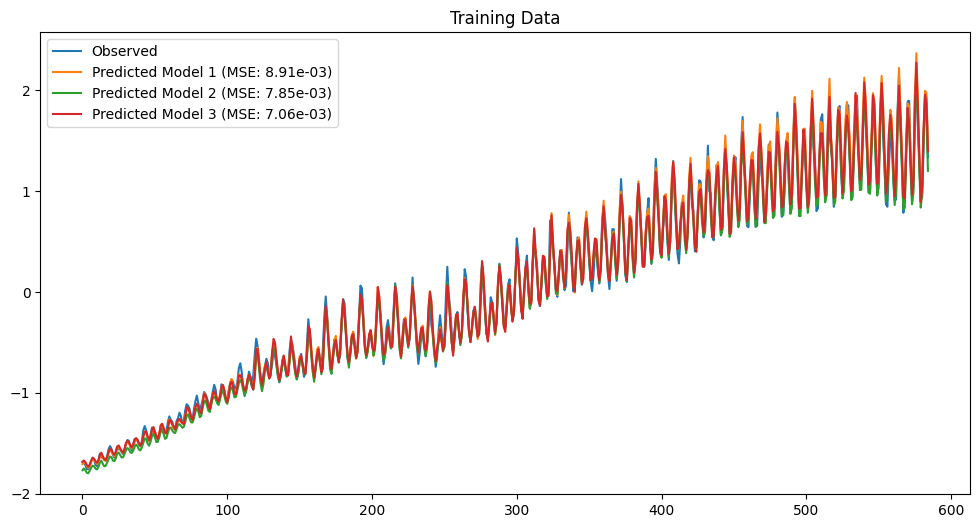

In [55]:
plt.figure(figsize=(12, 6))
plt.plot(y_train, label='Observed')
plt.plot(y_train_pred_1, label=f'Predicted Model 1 (MSE: {mse_train_1:.2e})')
plt.plot(y_train_pred_2, label=f'Predicted Model 2 (MSE: {mse_train_2:.2e})')
plt.plot(y_train_pred_3, label=f'Predicted Model 3 (MSE: {mse_train_3:.2e})')
plt.title('Training Data')
plt.legend()


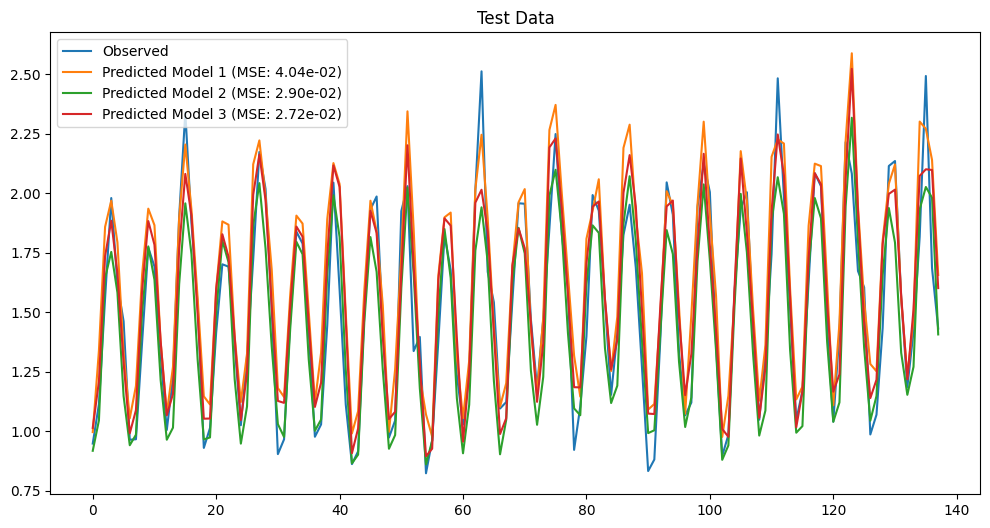

In [56]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Observed')
plt.plot(y_test_pred_1, label=f'Predicted Model 1 (MSE: {mse_test_1:.2e})')
plt.plot(y_test_pred_2, label=f'Predicted Model 2 (MSE: {mse_test_2:.2e})')
plt.plot(y_test_pred_3, label=f'Predicted Model 3 (MSE: {mse_test_3:.2e})')
plt.title('Test Data')
plt.legend()


In [57]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Función para calcular RMSE, MAE, MAPE y MASE
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return rmse, mae, mape

# Calcular métricas para cada modelo
rmse_train_1, mae_train_1, mape_train_1,  = calculate_metrics(y_train, y_train_pred_1)
rmse_test_1, mae_test_1, mape_test_1,  = calculate_metrics(y_test, y_test_pred_1)

rmse_train_2, mae_train_2, mape_train_2,  = calculate_metrics(y_train, y_train_pred_2)
rmse_test_2, mae_test_2, mape_test_2,  = calculate_metrics(y_test, y_test_pred_2)

rmse_train_3, mae_train_3, mape_train_3,  = calculate_metrics(y_train, y_train_pred_3)
rmse_test_3, mae_test_3, mape_test_3,  = calculate_metrics(y_test, y_test_pred_3)

# Crear tabla de resultados
results_table = pd.DataFrame({
    'Model': ['Model 1', 'Model 2', 'Model 3'],
    'MSE_train' : [mse_train_1, mse_train_2, mse_train_3],
    'RMSE_train': [rmse_train_1, rmse_train_2, rmse_train_3],
    'MAE_train': [mae_train_1, mae_train_2, mae_train_3],
    'MAPE_train': [mape_train_1, mape_train_2, mape_train_3],
    'MSE_test' : [mse_test_1, mse_test_2, mse_test_3],
    'RMSE_test': [rmse_test_1, rmse_test_2, rmse_test_3],
    'MAE_test': [mae_test_1, mae_test_2, mae_test_3],
    'MAPE_test': [mape_test_1, mape_test_2, mape_test_3],
})

results_table


Model  MSE_train  RMSE_train  MAE_train  MAPE_train  MSE_test  RMSE_test  \
0  Model 1   0.008914    0.094411   0.067932  359.719182  0.040404   0.201007   
1  Model 2   0.007849    0.088597   0.067929  347.289871  0.029025   0.170366   
2  Model 3   0.007058    0.084009   0.060814  352.136401  0.027179   0.164859   

   MAE_test  MAPE_test  
0  0.154424  35.903757  
1  0.133721  32.130844  
2  0.127420  33.929456

## 5.4 RNN

In [58]:
# modelos

def SimpleRNN_(n_units = 10, l1_reg=0, seed=0):
  model = keras.models.Sequential()
  model.add(keras.layers.SimpleRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=keras.regularizers.l1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True, stateful=False))  
  model.add(keras.layers.Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=keras.regularizers.l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model


def GRU_(n_units = 10, l1_reg=0, seed=0):
  model = keras.models.Sequential()
  model.add(keras.layers.GRU(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=keras.regularizers.l1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True))  
  model.add(keras.layers.Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=keras.regularizers.l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model


def LSTM_(n_units = 10, l1_reg=0, seed=0):
  model = keras.models.Sequential()
  model.add(keras.layers.LSTM(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=keras.regularizers.l1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True)) 
  model.add(keras.layers.Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=keras.regularizers.l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [59]:
max_epochs = 20 
batch_size = 16

In [60]:
es = keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10, min_delta=1e-7, restore_best_weights=True)

In [61]:
params = {
    'rnn': {
        'model': None, 'function': SimpleRNN_, 'l1_reg': 0.0, 'H': 20, 
        'color': 'blue', 'label':'RNN'}, 
    'gru': {
        'model': None, 'function':GRU_,'l1_reg': 0.0, 'H': 10, 
        'color': 'orange', 'label': 'GRU'},
    'lstm': {
        'model': None, 'function': LSTM_,'l1_reg': 0.0, 'H': 10, 
        'color':'red', 'label': 'LSTM'}
}

In [62]:
cross_val = True # WARNING: Changing this to True will take many hours to run
do_training = True

if do_training and cross_val:
    n_units = [5, 10, 20]
    l1_reg = [0, 0.001, 0.01, 0.1]
    
    # A dictionary containing a list of values to be iterated through
    # for each parameter of the model included in the search
    param_grid = {'n_units': n_units, 'l1_reg': l1_reg}
    
    # In the kth split, TimeSeriesSplit returns first k folds 
    # as training set and the (k+1)th fold as test set.
    tscv = TimeSeriesSplit(n_splits = 5)
    
    # A grid search is performed for each of the models, and the parameter set which
    # performs best over all the cross-validation splits is saved in the `params` dictionary
    for key in params.keys():
        print('Performing cross-validation. Model:', key)
        model = keras.wrappers.scikit_learn.KerasRegressor(build_fn=params[key]['function'], epochs=max_epochs, 
                               batch_size=batch_size, verbose=2)
        #from scikeras.wrappers import KerasClassifier, KerasRegressor
        grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                            cv=tscv, n_jobs=1, verbose=2)
        grid_result = grid.fit(x_train, y_train, callbacks=[es])
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params_ = grid_result.cv_results_['params']
        for mean, stdev, param_ in zip(means, stds, params_):
            print("%f (%f) with %r" % (mean, stdev, param_))
            
        params[key]['H'] = grid_result.best_params_['n_units']
        params[key]['l1_reg']= grid_result.best_params_['l1_reg']

Performing cross-validation. Model: rnn
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Epoch 1/20
7/7 - 2s - loss: 0.6333 - 2s/epoch - 233ms/step
Epoch 2/20
7/7 - 0s - loss: 0.5244 - 64ms/epoch - 9ms/step
Epoch 3/20
7/7 - 0s - loss: 0.4285 - 48ms/epoch - 7ms/step
Epoch 4/20
7/7 - 0s - loss: 0.3469 - 30ms/epoch - 4ms/step
Epoch 5/20
7/7 - 0s - loss: 0.2819 - 30ms/epoch - 4ms/step
Epoch 6/20
7/7 - 0s - loss: 0.2237 - 35ms/epoch - 5ms/step
Epoch 7/20
7/7 - 0s - loss: 0.1815 - 19ms/epoch - 3ms/step
Epoch 8/20
7/7 - 0s - loss: 0.1460 - 23ms/epoch - 3ms/step
Epoch 9/20
7/7 - 0s - loss: 0.1196 - 19ms/epoch - 3ms/step
Epoch 10/20
7/7 - 0s - loss: 0.0999 - 18ms/epoch - 3ms/step
Epoch 11/20
7/7 - 0s - loss: 0.0861 - 18ms/epoch - 3ms/step
Epoch 12/20
7/7 - 0s - loss: 0.0758 - 20ms/epoch - 3ms/step
Epoch 13/20
7/7 - 0s - loss: 0.0680 - 24ms/epoch - 3ms/step
Epoch 14/20
7/7 - 0s - loss: 0.0633 - 23ms/epoch - 3ms/step
Epoch 15/20
7/7 - 0s - loss: 0.0592 - 23ms/epoch - 3ms/step
Epoch 16

In [63]:
if do_training is True:
    for key in params.keys():
        tf.random.set_seed(0)
        print('Training', key, 'model')
        model = params[key]['function'](params[key]['H'], params[key]['l1_reg'])
        model.fit(x_train, y_train, epochs=max_epochs, 
                  batch_size=batch_size, callbacks=[es], shuffle=False)
        params[key]['model'] = model

Training rnn model
Epoch 1/20
37/37 [==============================] - 1s 2ms/step - loss: 2.0937
Epoch 2/20
37/37 [==============================] - 0s 3ms/step - loss: 0.8845
Epoch 3/20
37/37 [==============================] - 0s 2ms/step - loss: 0.2562
Epoch 4/20
37/37 [==============================] - 0s 5ms/step - loss: 0.1726
Epoch 5/20
37/37 [==============================] - 0s 3ms/step - loss: 0.1774
Epoch 6/20
37/37 [==============================] - 0s 2ms/step - loss: 0.1512
Epoch 7/20
37/37 [==============================] - 0s 3ms/step - loss: 0.1504
Epoch 8/20
37/37 [==============================] - 0s 2ms/step - loss: 0.1304
Epoch 9/20
37/37 [==============================] - 0s 2ms/step - loss: 0.1308
Epoch 10/20
37/37 [==============================] - 0s 2ms/step - loss: 0.1134
Epoch 11/20
37/37 [==============================] - 0s 2ms/step - loss: 0.1156
Epoch 12/20
37/37 [==============================] - 0s 2ms/step - loss: 0.0990
Epoch 13/20
37/37 [===========

In [64]:
for key in params.keys():
    model = params[key]['model']
    model.summary()
    
    params[key]['pred_train'] = model.predict(x_train, verbose=1)
    params[key]['MSE_train'] = mean_squared_error(y_train, params[key]['pred_train'])
    
    params[key]['pred_test'] = model.predict(x_test, verbose=1) 
    params[key]['MSE_test'] = mean_squared_error(y_test, params[key]['pred_test'])

Model: "sequential_546"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_61 (SimpleRNN)   (None, 20)                440       
                                                                 
 dense_1514 (Dense)          (None, 1)                 21        
                                                                 
Total params: 461
Trainable params: 461
Non-trainable params: 0
_________________________________________________________________
5/5 [==============================] - 0s 2ms/step
Model: "sequential_547"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_61 (GRU)                (None, 20)                1380      
                                                                 
 dense_1515 (Dense)          (None, 1)                 21        
                                             

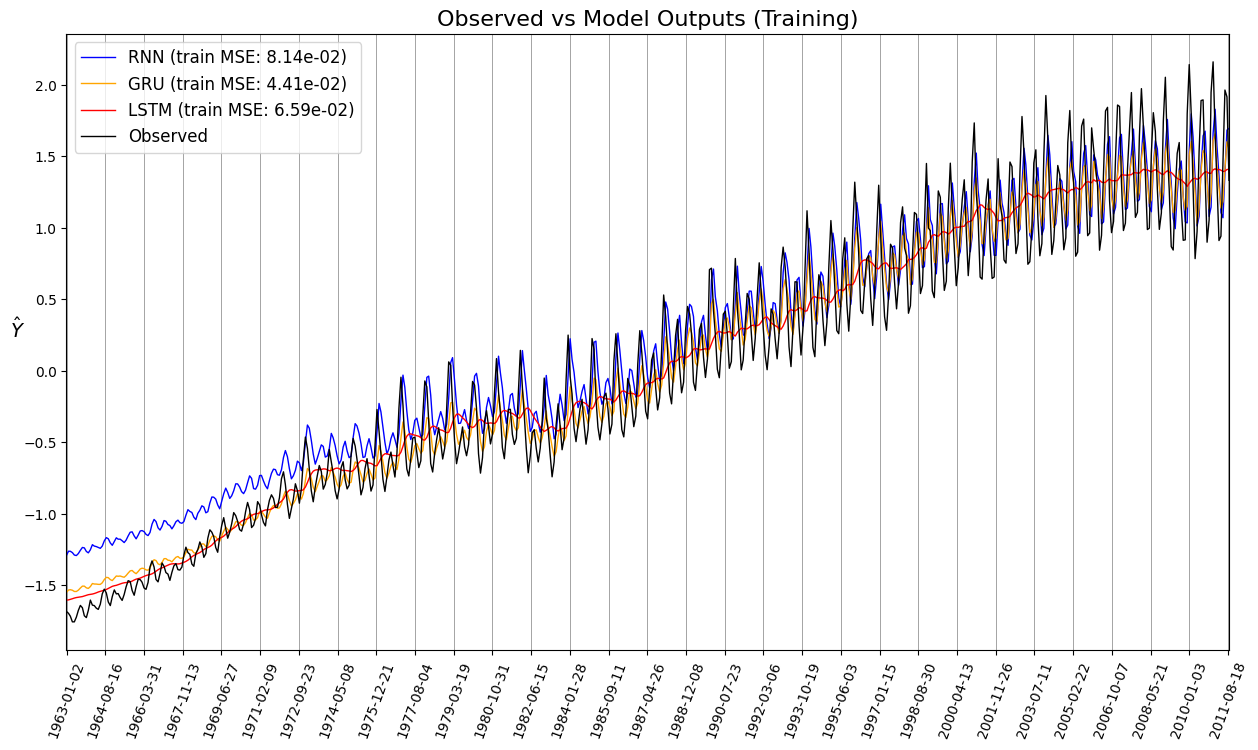

In [65]:
max_pts = 10**4
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable. 

fig = plt.figure(figsize=(15,8))
x_vals = y_train_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_train'][l:u:ds]
    label = params[key]['label'] + ' (train MSE: %.2e)' % params[key]['MSE_train']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
plt.plot(x_vals, y_train[l:u:ds], c="black", label="Observed", lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=70)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Training)', fontsize=16);

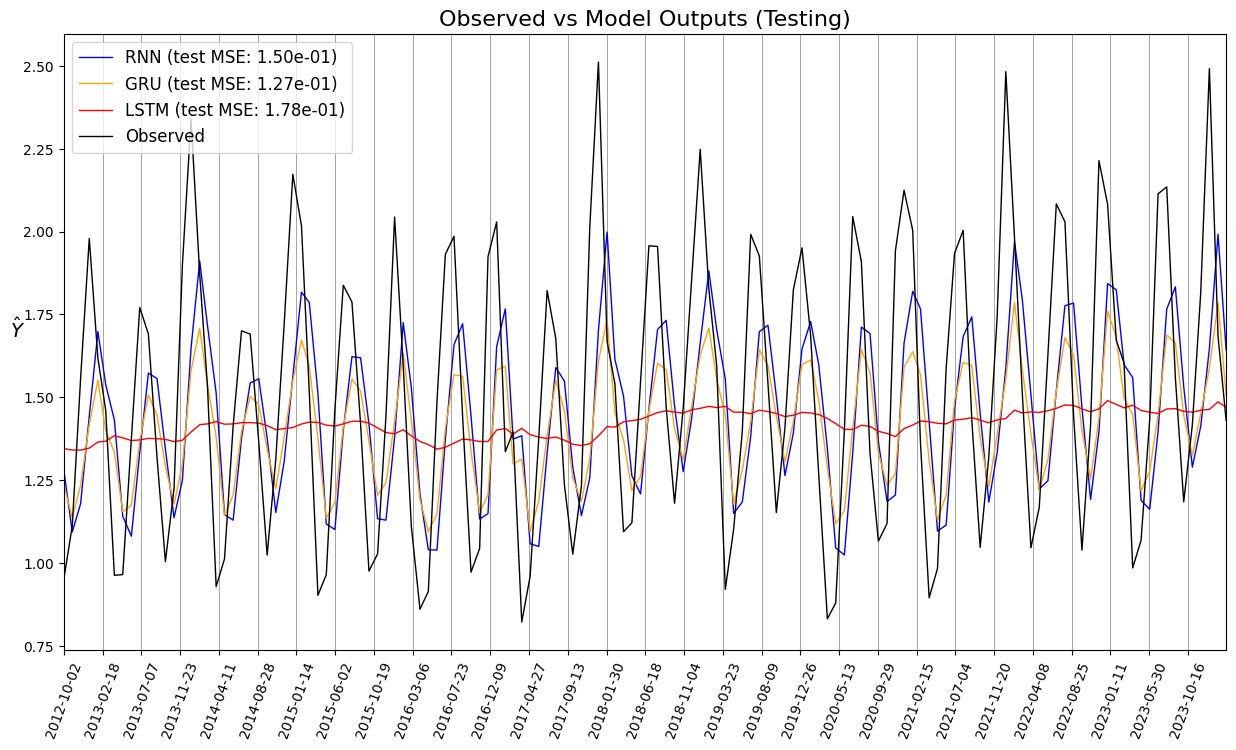

In [66]:
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable.
fig = plt.figure(figsize=(15,8))
x_vals = y_test_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_test'][l:u:ds]
    label = params[key]['label'] + ' (test MSE: %.2e)' % params[key]['MSE_test']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
plt.plot(x_vals, y_test[l:u:ds], c="black", label="Observed", lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=70)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Testing)', fontsize=16);

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.metrics import mean_squared_error

# Calculate error metrics
error_metrics = {}
for key in params.keys():
    model = params[key]['model']
    pred_train = params[key]['pred_train']
    pred_test = params[key]['pred_test']
    
    rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
    mae_train = np.mean(np.abs(y_train - pred_train))
    mape_train = np.mean(np.abs((y_train - pred_train) / y_train)) * 100
    
    # Calculate MASE for training data
    denom_train = np.mean(np.abs(y_train[1:] - y_train[:-1]))
    mase_train = np.mean(np.abs((y_train - pred_train) / denom_train))
    
    rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))
    mae_test = np.mean(np.abs(y_test - pred_test))
    mape_test = np.mean(np.abs((y_test - pred_test) / y_test)) * 100
    
    # Calculate MASE for testing data
    denom_test = np.mean(np.abs(y_test[1:] - y_test[:-1]))
    mase_test = np.mean(np.abs((y_test - pred_test) / denom_test))
    
    error_metrics[key] = {
        'RMSE_train': rmse_train, 'MAE_train': mae_train, 'MAPE_train': mape_train, 'MASE_train': mase_train,
        'RMSE_test': rmse_test, 'MAE_test': mae_test, 'MAPE_test': mape_test, 'MASE_test': mase_test
    }

# Store error metrics in a data frame
error_metrics_df = pd.DataFrame(error_metrics).T.reset_index()
error_metrics_df.columns = ['Model', 'RMSE_train', 'MAE_train', 'MAPE_train', 'MASE_train',
                            'RMSE_test', 'MAE_test', 'MAPE_test', 'MASE_test']

# Display error metrics table
error_metrics_df


Model  RMSE_train  MAE_train  MAPE_train  MASE_train  RMSE_test  MAE_test  \
0   rnn    0.285274   1.061231  314.580252    5.690642   0.387873  0.398214   
1   gru    0.209967   1.098205  338.959515    5.888908   0.356643  0.379182   
2  lstm    0.256725   1.099076  336.253754    5.893580   0.421730  0.352891   

   MAPE_test  MASE_test  
0  27.869192   1.097514  
1  25.936769   1.045060  
2  24.152859   0.972599

# 6. Mejores modelos

In [68]:
model_rnn = error_metrics_df[['Model','RMSE_test', 'MAE_test', 'MAPE_test']]
model_rnn.rename(columns={'RMSE_test': 'RMSE', 'MAE_test': 'MAE', 'MAPE_test': 'MAPE'}, inplace=True)
model_rnn

Model      RMSE       MAE       MAPE
0   rnn  0.387873  0.398214  27.869192
1   gru  0.356643  0.379182  25.936769
2  lstm  0.421730  0.352891  24.152859

In [69]:
model_NN = results_table[['Model', 'RMSE_test', 'MAE_test', 'MAPE_test']]
model_NN.rename(columns={'RMSE_test': 'RMSE', 'MAE_test': 'MAE', 'MAPE_test': 'MAPE'}, inplace=True)

In [70]:
error_metrics_sarima

Model       RMSE       MAE      MAPE      MASE
1   SARIMA (2,0,2)(0,1,1)[12]  11.016951  9.760369  9.630362  3.946544
2  SARIMA (1,0,13)(0,1,0)[12]   3.681239  2.924519  2.819925  1.182511

In [71]:
error_metrics_ETS

Model       RMSE        MAE       MAPE      MASE
1               Additive  11.209675   9.958719   9.807272  4.026745
2        Additive Damped   3.653966   2.899310   2.801727  1.172318
3         Multiplicative  13.002036  11.452741  11.157767  4.630844
4  Multiplicative Damped   3.644674   2.903812   2.811191  1.174138

In [72]:
result = pd.concat([error_metrics_ETS, error_metrics_sarima, model_NN, model_rnn], axis=0).drop(columns=['MASE', 'MAPE'])
result['Avg'] = result[['RMSE', 'MAE']].mean(axis=1)
result.sort_values(by='Avg', ascending=True).reset_index().drop(columns=['index', 'Avg'])

Model       RMSE        MAE
0                      Model 3   0.164859   0.127420
1                      Model 2   0.170366   0.133721
2                      Model 1   0.201007   0.154424
3                          gru   0.356643   0.379182
4                         lstm   0.421730   0.352891
5                          rnn   0.387873   0.398214
6        Multiplicative Damped   3.644674   2.903812
7              Additive Damped   3.653966   2.899310
8   SARIMA (1,0,13)(0,1,0)[12]   3.681239   2.924519
9    SARIMA (2,0,2)(0,1,1)[12]  11.016951   9.760369
10                    Additive  11.209675   9.958719
11              Multiplicative  13.002036  11.452741

# Notas

## Tareas pendientes 07/05/2022:


1.  Estacionalidad:
- Sarima = ARIMA (Pasado reciente) + estacionalidad, 
- auto.arima (R) => Con frecuencia mensual, (P, Q, D)

1.5. Mejorar modelos con libro de hiltman y ajustar hyperparameters con LSTM y BRNN, Sobre ajustes con regularización

2. Revisión documental de GANS

## Notas video

Here are the study notes with expanded explanations for the key concepts:

1. Introduction to Probabilistic Forecasts
   - Probabilistic forecasts explicitly acknowledge uncertainty by providing probabilistic statements about future outcomes instead of single point forecasts.
   - Types:
     - Quantile forecasts: Provide quantile values, e.g., 90% quantile means there is a 90% probability that the actual value will be less than or equal to the quantile value.
     - Interval forecasts: Provide a range (interval) that the actual value is expected to fall within with a specified probability, e.g., 80% prediction interval.
     - Predictive densities: Provide the entire probability distribution of the future outcomes.
   - Importance: Probabilistic forecasts are crucial for decision-making tasks that require accounting for uncertainty and risk, such as capacity planning (e.g., call center staffing) and safety stock setting (e.g., inventory management).

2. Evaluating Quantile Forecasts
   - Quantile forecast: A value Q_hat such that the probability of the actual value Y being less than or equal to Q_hat is α, i.e., P(Y ≤ Q_hat) = α.
   - Evaluation metric: Pinball loss, a loss function that penalizes the deviation of the quantile forecast from the actual observation, taking into account the quantile level α. It is minimized in expectation by the correct quantile forecast.

3. Evaluating Interval Forecasts
   - Central prediction interval: An interval forecast with equal probability masses in the tails, e.g., the 10% and 90% quantiles define an 80% central prediction interval.
   - Evaluation metric: Winkler score, which combines a sharpness term (interval width) and a calibration term (whether the observation falls within the interval). It is a consistent scoring function, minimized in expectation by the correct central prediction interval.

4. Evaluating Predictive Densities
   - Proper scoring rules: Loss functions that are minimized in expectation by the true (or correct) predictive density, e.g., log score, Continuous Ranked Probability Score (CRPS).
   - Properties:
     - Proper: Minimized in expectation by the true density, but other densities may achieve the same minimum score.
     - Strictly proper: Minimized only by the true density, providing a unique optimum.

5. Scaling for Comparability
   - When forecasting multiple time series with different scales (e.g., sales of different products), it is useful to scale the scores for better comparability.
   - Scaling techniques:
     - Scale by a benchmark score (e.g., historical average forecast)
     - Scale by the series' mean level

6. Pitfalls of Accuracy Estimation
   - Scores are estimated based on finite test data, which introduces variability and potential overfitting.
   - The ranking of competing forecasts based on estimated scores may not reflect the true ranking, as scores are realizations of random variables.

7. Beyond Accuracy
   - Accuracy (as measured by scores) is not an end in itself; the ultimate goal is driving business value.
   - Other considerations:
     - Data requirements: More data-hungry methods may not provide enough value to justify the cost.
     - Resource requirements: Computationally expensive methods may not be worth the resources (time, computing power, etc.).
     - Explainability and maintainability: Simpler, more interpretable methods may be preferred for ease of understanding, debugging, and maintenance.




- se presentaria una metodologia a un problema de pronostico probabilistico de series de tiempo, con evaluación de metricas 

que adaptación es mejor de los modelos al pronnostico probabilistico

- En ingles